In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

In [2]:
df=pd.read_csv('data_redacted.tsv',sep='\t')

In [3]:
df.columns

Index(['title', 'text', 'url', 'category'], dtype='object')

In [4]:
df.shape


(8646, 4)

In [5]:
df.head()

,title,text,url,category
0,"Don""t Mourn the Y Chromosome","The human Y chromosome may vanish one day, but...",http://discovermagazine.com/2014/nov/13-y-not,technology_science
1,Destiny: Bungie to introduce ammo pack micro-t...,Bungie is putting together plans to start sell...,http://www.ibtimes.co.uk/destiny-bungie-introd...,digital_life
2,Daruvala to race for Josef Kaufmann Racing in ...,Highly rated Jehan Daruvala will race for Jose...,http://www.thecheckeredflag.co.uk/2015/12/daru...,sports
3,Secondary tropical forests absorb carbon at hi...,Forests are an important carbon sink. While mo...,http://www.sciencedaily.com/releases/2016/02/1...,technology_science
4,This Brow Hack Will Change the Way You Fill In...,Before everyone was trying to get eyebrows on ...,http://www.popsugar.com/beauty/How-Use-Brow-Ge...,fashion_beauty_lifestyle


In [6]:
df.describe().transpose()

,count,unique,top,freq
title,8646,8639,The 10 things in advertising you need to know ...,3
text,8646,8646,Chancellor George Osborne has said a Conservat...,1
url,8646,8646,http://www.femalefirst.co.uk/tv/news/simon-cow...,1
category,8646,12,fashion_beauty_lifestyle,1398


##### We can observe almost all the urls are unique and they dont provide much information regarding news classification

In [7]:
df['title'].value_counts().count()

8639

##### Also it seems most of the titles are unique,and all the info in Title is also visible in News text. So its better to remove the Title
##### As a conclusion we can treat text column as input and category as output.

### Data Cleaning/EDA

In [8]:
df.isnull().sum().sort_values(ascending=False)

title       0
text        0
url         0
category    0
dtype: int64

#### Dropping title and url columns as they seems to be not very useful

In [9]:
df.drop(columns=['url','title'],inplace=True)

##### Applying basic cleaning  : Below  function converts the data to lower-case, removes square brackets,removes numbers and new line charecter


In [10]:
import re 
import string 
def text_cleaner(text):
    text=text.lower()
    text=re.sub('\[.*?\]','',text)
    text=re.sub('\w*\d\w*','',text)
    text=re.sub('\n','',text)  
    return text

cleaner=lambda x:text_cleaner(x)
    
    

In [11]:
df['cleaned_text']=pd.DataFrame(df['text'].apply(cleaner))


In [12]:
df.head()

,text,category,cleaned_text
0,"The human Y chromosome may vanish one day, but...",technology_science,"the human y chromosome may vanish one day, but..."
1,Bungie is putting together plans to start sell...,digital_life,bungie is putting together plans to start sell...
2,Highly rated Jehan Daruvala will race for Jose...,sports,highly rated jehan daruvala will race for jose...
3,Forests are an important carbon sink. While mo...,technology_science,forests are an important carbon sink. while mo...
4,Before everyone was trying to get eyebrows on ...,fashion_beauty_lifestyle,before everyone was trying to get eyebrows on ...


In [13]:
X=df['cleaned_text']
y=df['category']

In [14]:
X.shape,y.shape

((8646,), (8646,))

In [15]:
X

0       the human y chromosome may vanish one day, but...
1       bungie is putting together plans to start sell...
2       highly rated jehan daruvala will race for jose...
3       forests are an important carbon sink. while mo...
4       before everyone was trying to get eyebrows on ...
                              ...                        
8641    since when did pubic hair become so yucky? sur...
8642    what’s your reaction? thanks for your reaction...
8643    ‘what the hell is “new baltic cuisine” when it...
8644    if achieving a healthier lifestyle is one of y...
8645    the firm has completed three years as the nort...
Name: cleaned_text, Length: 8646, dtype: object

### Data Preprocessing 

##### Since the input X is in text format, we need to use CountVectorizer or TfidfVEctorizer. I have used Tfidfvectorizer because it performs better than CountVectorizer.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect=TfidfVectorizer(stop_words='english')
X_vec= vect.fit_transform(X)
print(X_vec.shape)

(8646, 96877)


<AxesSubplot:>

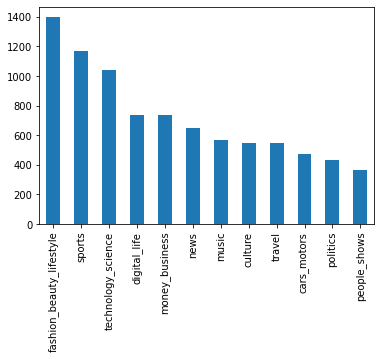

In [17]:
df['category'].value_counts().plot(kind='bar')

##### By seeing the bar chart we can observe that the data is imballenced.
##### To remove the imbalence in data we need to perform sampling of data.
##### Applying SMOTE oversampling technique.
##### Smote is a very effective sampling technique in generating new data.
##### Smote internally uses KNN to create new records.

In [18]:
from imblearn.over_sampling import SMOTE
sm=SMOTE(random_state=42)
X_sampled, y_sampled = sm.fit_resample(X_vec, y)

##### Splitting the data into train and test with test size=25% and train size=75% , I will check with diffrence train and test percentage to get maximum accuracy of model.

In [19]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_sampled,y_sampled,random_state=44,test_size=0.25)

In [20]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((12582, 96877), (4194, 96877), (12582,), (4194,))

In [21]:

from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,classification_report


##### Applying multinomial NB as it mostly used for text data.
##### It uses only one assumption that each feature is independent of each other.
##### Multinomial NB works very good for categorical features.

In [22]:
    from sklearn.naive_bayes import MultinomialNB
    nb=MultinomialNB()
    nb.fit(X_train,y_train)
    y_pred_nb=nb.predict(X_test)
    print(accuracy_score(y_test,y_pred_nb))
    print(precision_score(y_test,y_pred_nb,average='weighted'))
    print(recall_score(y_test,y_pred_nb,average='weighted'))
    print(classification_report(y_test,y_pred_nb))
  


0.8948497854077253
0.9034692308180601
0.8948497854077253
                          precision    recall  f1-score   support

             cars_motors       0.93      0.98      0.96       326
                 culture       0.83      0.93      0.87       355
            digital_life       0.96      0.92      0.94       354
fashion_beauty_lifestyle       0.91      0.68      0.78       364
          money_business       0.86      0.95      0.90       363
                   music       0.92      0.98      0.95       348
                    news       0.97      0.69      0.81       350
            people_shows       0.95      0.95      0.95       381
                politics       0.77      0.99      0.87       332
                  sports       1.00      0.93      0.97       320
      technology_science       0.94      0.76      0.84       361
                  travel       0.81      0.99      0.89       340

                accuracy                           0.89      4194
               ma

##### With multinomial Naive bias the accuracy found is nearly 89 %,and the prescision and recall is also not very good.
##### So i am trying SVM as it is best suggested for Text data.
##### It works very well with very high number of features. SVC works very well for complex data.
##### And we can use kernel tricks also to make it more accurate.


In [23]:
from sklearn.svm import SVC
svc=SVC()
svc.fit(X_train,y_train)
y_pred_svc=svc.predict(X_test)
print(accuracy_score(y_test,y_pred_svc))
print(precision_score(y_test,y_pred_svc,average='weighted'))
print(recall_score(y_test,y_pred_svc,average='weighted'))
print(classification_report(y_test,y_pred_svc))
  

0.9632808774439676
0.9640024356699181
0.9632808774439676
                          precision    recall  f1-score   support

             cars_motors       0.99      0.99      0.99       326
                 culture       0.97      0.95      0.96       355
            digital_life       0.97      0.95      0.96       354
fashion_beauty_lifestyle       0.85      0.90      0.88       364
          money_business       0.98      0.97      0.97       363
                   music       0.99      0.98      0.98       348
                    news       0.96      0.96      0.96       350
            people_shows       0.99      0.98      0.98       381
                politics       0.97      0.99      0.98       332
                  sports       0.98      0.99      0.98       320
      technology_science       0.93      0.94      0.93       361
                  travel       1.00      0.97      0.99       340

                accuracy                           0.96      4194
               ma

#### Support Vector Classifer gives very good accuracy of nearly 96 % . 

In [24]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(multi_class='ovr')
lr.fit(X_train,y_train)
y_pred_lr=lr.predict(X_test)
print(accuracy_score(y_test,y_pred_lr))
print(precision_score(y_test,y_pred_lr,average='weighted'))
print(recall_score(y_test,y_pred_lr,average='weighted'))
print(classification_report(y_test,y_pred_lr))

0.9427753934191703
0.9427832273067474
0.9427753934191703
                          precision    recall  f1-score   support

             cars_motors       0.96      0.98      0.97       326
                 culture       0.96      0.93      0.94       355
            digital_life       0.96      0.93      0.95       354
fashion_beauty_lifestyle       0.86      0.85      0.86       364
          money_business       0.92      0.96      0.94       363
                   music       0.96      0.98      0.97       348
                    news       0.93      0.92      0.92       350
            people_shows       0.97      0.98      0.97       381
                politics       0.94      0.98      0.96       332
                  sports       0.97      0.97      0.97       320
      technology_science       0.91      0.88      0.89       361
                  travel       0.97      0.96      0.97       340

                accuracy                           0.94      4194
               ma

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred_rfc=rfc.predict(X_test)
print(accuracy_score(y_test,y_pred_rfc))
print(precision_score(y_test,y_pred_rfc,average='weighted'))
print(recall_score(y_test,y_pred_rfc,average='weighted'))
print(classification_report(y_test,y_pred_rfc))


##### I tried  Adaboost,GradientBoost,Xgboost,Lasso,Ridge,Elasticnet also but i was not able to see good accuracy .
##### As a conclusion i found i am able to get best precision,recall,accuracy using Support Vector Classifer.
##### I tried multiple kernet trics also to imporove the accuracy but 96 % is maximum accuracy i could achieve.
##### Packaging the SVC model in pipeline with TfidfVectorizer for new prediction .



In [ ]:
import pickle

pipeline_svc=Pipeline([('vectorizer',vect),('classifier',svc)])
pickle.dump(pipeline_svc,open('classifer_model.pkl','wb'))